In [1]:
!pip install -q imbalanced-learn sastrawi tqdm
!pip install sastrawi
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary, StopWordRemover
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import pandas as pd
import numpy as np
df = pd.read_csv('ulasan_mpp.csv')
df

,user,review,rating,sentimen
0,Hunain,"Pertama kali datang kesini buat urus pasporr, ...",5,positif
1,Shelina Vidia Kharisma,Hari ini saya buat paspor baru di MPP Denpasar...,5,positif
2,serafim wibisono,ngurus ktp yang hilang dari polsek disuruh kes...,5,positif
3,Ismi Budiarti,Baru saja mengurus perpanjangan paspor di Mall...,4,positif
4,moonlight 08,Buat paspor baru disini. Pelayanannya cepat da...,5,positif
...,...,...,...,...
65,tariskaindri mutia,BAGUS BAGUS BAGUS,5,positif
66,Eva F Simangunsong,Ibu petugas bagian imigrasi nya ramah dan pela...,5,positif
67,Hadi Abraham,Saya pribadi ingin mengucapkan terima kasih ke...,5,positif
68,Richie Rick,"Pelayanan satu atap, lengkap dan cepat",5,positif


In [2]:
df.shape

(70, 4)

In [3]:
df.columns

Index(['user', 'review', 'rating', 'sentimen'], dtype='object')

In [4]:
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

Jumlah data per kelas sentimen:
sentimen
positif    40
negatif    24
netral      6
Name: count, dtype: int64


In [5]:
def clean_text(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df['review'] = df['review'].apply(clean_text)
df

,user,review,rating,sentimen
0,Hunain,pertama kali datang kesini buat urus pasporr d...,5,positif
1,Shelina Vidia Kharisma,hari ini saya buat paspor baru di mpp denpasar...,5,positif
2,serafim wibisono,ngurus ktp yang hilang dari polsek disuruh kes...,5,positif
3,Ismi Budiarti,baru saja mengurus perpanjangan paspor di mall...,4,positif
4,moonlight 08,buat paspor baru disini pelayanannya cepat dan...,5,positif
...,...,...,...,...
65,tariskaindri mutia,bagus bagus bagus,5,positif
66,Eva F Simangunsong,ibu petugas bagian imigrasi nya ramah dan pela...,5,positif
67,Hadi Abraham,saya pribadi ingin mengucapkan terima kasih ke...,5,positif
68,Richie Rick,pelayanan satu atap lengkap dan cepat,5,positif


In [6]:
df_norm = df["review"]
df_norm
norm = {
    " pasporr " : " paspor ",
    " bgt " : " sekali ", " bgtt " : " sekali ",
    " ga " : " tidak ",
    " ga " : " tidak ",
    " oiya " : " oh ya ",
    " sy " : " saya ",
    " yg " : " yang ",
    " gk " : " tidak ",
    " disini " : " di sini ",
    " ngurus " : " mengurus ",
    " utk " : " untuk ",
    " dr " : " dari ",
    " cepet " : " cepat ",
    " kasih " : " terima kasih ",
    " m " : " saya ",
    " banget " : " sangat ",
    " aja " : " saja ",
    " pas " : " saat ",
    " antri " : " antre ",
    " online " : " daring ",
    " foto " : " pemotretan ",
    " buat " : " untuk ",
    " aja " : " saja ",
    " ga " : " tidak ",
    " gk " : " tidak ",
    " nggak " : " tidak",
    " ok " : " oke ",
    " oke " : " baik ",
    " tq " : " terima kasih ",
    " jd " : " jadi ",
    " dgn " : " dengan ",
    " udh " : " sudah ",
    " bgt " : " banget ",
    " tdk " : " tidak ",
    " tp " : " tapi ",
    " sy " : " saya ",
    " blm ": " belum "
}

def normalisasi(str_text):
    for i in norm:
        str_text = str_text.replace(i, norm[i])
    return str_text

df["review"] = df["review"].apply(normalisasi)
df

,user,review,rating,sentimen
0,Hunain,pertama kali datang kesini untuk urus paspor d...,5,positif
1,Shelina Vidia Kharisma,hari ini saya untuk paspor baru di mpp denpasa...,5,positif
2,serafim wibisono,ngurus ktp yang hilang dari polsek disuruh kes...,5,positif
3,Ismi Budiarti,baru saja mengurus perpanjangan paspor di mall...,4,positif
4,moonlight 08,buat paspor baru di sini pelayanannya cepat da...,5,positif
...,...,...,...,...
65,tariskaindri mutia,bagus bagus bagus,5,positif
66,Eva F Simangunsong,ibu petugas bagian imigrasi nya ramah dan pela...,5,positif
67,Hadi Abraham,saya pribadi ingin mengucapkan terima terima k...,5,positif
68,Richie Rick,pelayanan satu atap lengkap dan cepat,5,positif


In [7]:
stop_factory = StopWordRemoverFactory()
stopword_dict = ArrayDictionary(stop_factory.get_stop_words())
stop_remover = StopWordRemover(stopword_dict)

def remove_stopwords(text):
    return stop_remover.remove(text)

df["review"] = df["review"].apply(remove_stopwords)
df

,user,review,rating,sentimen
0,Hunain,pertama kali datang kesini urus paspor datang ...,5,positif
1,Shelina Vidia Kharisma,hari paspor baru mpp denpasar overall pelayana...,5,positif
2,serafim wibisono,ngurus ktp hilang polsek disuruh kesini di sin...,5,positif
3,Ismi Budiarti,baru mengurus perpanjangan paspor mall pelayan...,4,positif
4,moonlight 08,buat paspor baru sini pelayanannya cepat memua...,5,positif
...,...,...,...,...
65,tariskaindri mutia,bagus bagus bagus,5,positif
66,Eva F Simangunsong,ibu petugas bagian imigrasi nya ramah pelayana...,5,positif
67,Hadi Abraham,pribadi mengucapkan terima terima kasih ibu de...,5,positif
68,Richie Rick,pelayanan satu atap lengkap cepat,5,positif


In [8]:
tokenized = df["review"].apply(lambda x: x.split())
tokenized

,review
0,"[pertama, kali, datang, kesini, urus, paspor, ..."
1,"[hari, paspor, baru, mpp, denpasar, overall, p..."
2,"[ngurus, ktp, hilang, polsek, disuruh, kesini,..."
3,"[baru, mengurus, perpanjangan, paspor, mall, p..."
4,"[buat, paspor, baru, sini, pelayanannya, cepat..."
...,...
65,"[bagus, bagus, bagus]"
66,"[ibu, petugas, bagian, imigrasi, nya, ramah, p..."
67,"[pribadi, mengucapkan, terima, terima, kasih, ..."
68,"[pelayanan, satu, atap, lengkap, cepat]"


In [9]:
!pip install sastrawi tqdm
import pandas as pd
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from tqdm.notebook import tqdm
tqdm.pandas()

stemmer = StemmerFactory().create_stemmer()

def stemming(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

df["review"] = df["review"].progress_apply(stemming)
df

  0%|          | 0/70 [00:00<?, ?it/s]

,user,review,rating,sentimen
0,Hunain,pertama kali datang kesini urus paspor datang ...,5,positif
1,Shelina Vidia Kharisma,hari paspor baru mpp denpasar overall layan ba...,5,positif
2,serafim wibisono,ngurus ktp hilang polsek suruh kesini di sini ...,5,positif
3,Ismi Budiarti,baru urus panjang paspor mall layan publik den...,4,positif
4,moonlight 08,buat paspor baru sini layan cepat muas saya ba...,5,positif
...,...,...,...,...
65,tariskaindri mutia,bagus bagus bagus,5,positif
66,Eva F Simangunsong,ibu tugas bagi imigrasi nya ramah layan ibu ce...,5,positif
67,Hadi Abraham,pribadi ucap terima terima kasih ibu desi tang...,5,positif
68,Richie Rick,layan satu atap lengkap cepat,5,positif


In [10]:
# AUGMENTASI TEKS
!pip install -q nlpaug
import nlpaug.augmenter.word as naw
import random

# Inisialisasi augmenter
synonym_aug = naw.SynonymAug(aug_src='wordnet')
random_swap_aug = naw.RandomWordAug(action="swap")
random_insert_aug = naw.RandomWordAug(action="insert")

# Fungsi untuk meng-augmentasi tiap kalimat sebanyak n_aug kali
def augment_teks(text, label, n_aug=2):
    hasil_aug = []
    for _ in range(n_aug):
        metode = random.choice([synonym_aug, random_swap_aug, random_insert_aug])
        try:
            augmented_text = metode.augment(text)
            hasil_aug.append((augmented_text, label))
        except:
            pass  # lewati jika gagal augmentasi (misalnya terlalu pendek)
    return hasil_aug

# Proses augmentasi ke seluruh dataset
augmented_data = []

for i, row in df.iterrows():
    original_text = row['review']
    original_label = row['sentimen']
    augmented_samples = augment_teks(original_text, original_label, n_aug=2)  # Bisa ubah n_aug sesuai kebutuhan
    augmented_data.extend(augmented_samples)

# Buat DataFrame dari hasil augmentasi
df_aug = pd.DataFrame(augmented_data, columns=['review', 'sentimen'])

# Gabungkan dengan data asli
df = pd.concat([df, df_aug], ignore_index=True)
print("Jumlah data setelah augmentasi:", len(df))

Jumlah data setelah augmentasi: 116


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

Jumlah data per kelas sentimen:
sentimen
positif    64
netral     64
negatif    64
Name: count, dtype: int64


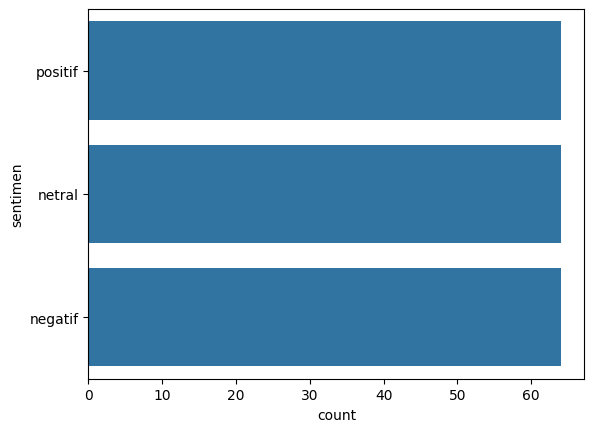

In [11]:
def balance_data(df, label_col):
    max_count = df[label_col].value_counts().max()
    balanced_df = pd.concat([
        resample(df[df[label_col] == cls], replace=True, n_samples=max_count, random_state=42)
        for cls in df[label_col].unique()
    ])
    return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

df = balance_data(df, 'sentimen')

import seaborn as sns
sns.countplot(df['sentimen'])
print("Jumlah data per kelas sentimen:")
print(df['sentimen'].value_counts())

In [12]:
X = df['review'].astype(str)
y = df['sentimen']

X_train_text, X_test_text, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print(X_train.shape[1])

579


In [13]:
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

In [14]:
model = LinearSVC()
model.fit(X_train, y_train)

LinearSVC()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 0.01}
Akurasi: 0.97

Classification Report:
               precision    recall  f1-score   support

     negatif       0.93      1.00      0.96        13
      netral       1.00      1.00      1.00        13
     positif       1.00      0.92      0.96        13

    accuracy                           0.97        39
   macro avg       0.98      0.97      0.97        39
weighted avg       0.98      0.97      0.97        39



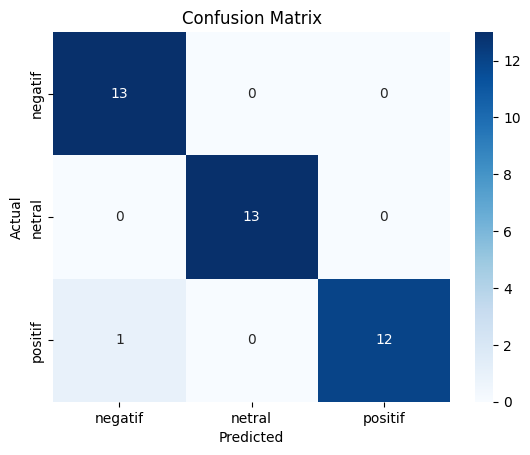

In [15]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
svm = LinearSVC(max_iter=10000)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Ambil model terbaik
best_svm = grid_search.best_estimator_

y_pred = best_svm.predict(X_test)

print("Akurasi:", round(accuracy_score(y_test, y_pred), 2))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Optional: Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
tfidf_sum = X_train.sum(axis=0).A1

top_words_df = pd.DataFrame({
    'Kata': feature_names,
    'Skor_TFIDF': tfidf_sum
}).sort_values(by='Skor_TFIDF', ascending=False)

print(top_words_df.head(20))

         Kata  Skor_TFIDF
284     layan   11.186857
113     cepat    6.983986
445    sangat    6.857654
315       mau    6.378515
451      satu    6.332806
426     ramah    6.185330
388    paspor    6.104426
39        apa    6.081996
385   panjang    5.574086
57      bagus    5.369213
38      antri    5.363966
362      nyak    5.262334
486       sim    5.262334
96        bsa    5.262334
487      sini    5.195149
552     tugas    5.076003
205  imigrasi    4.912916
64      bantu    4.656512
419    publik    4.653458
141        di    4.429666


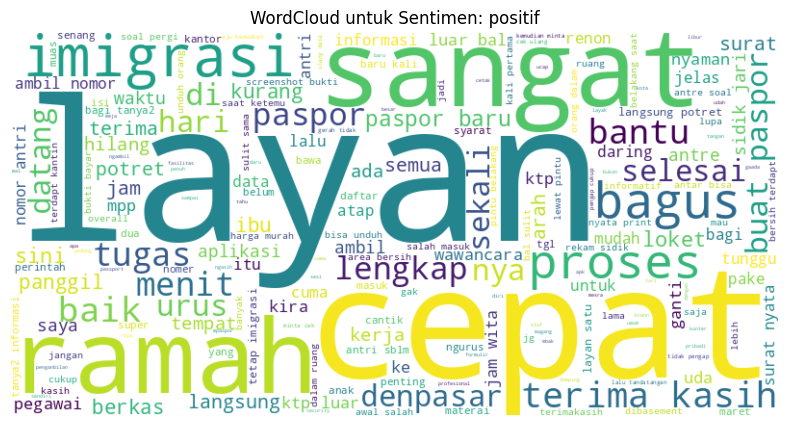

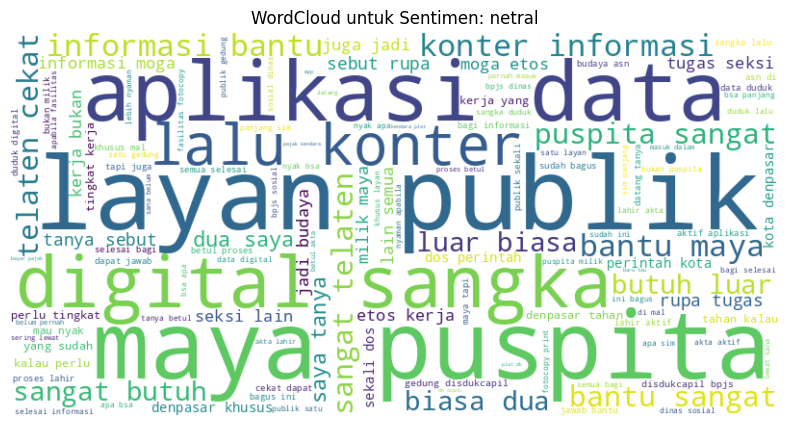

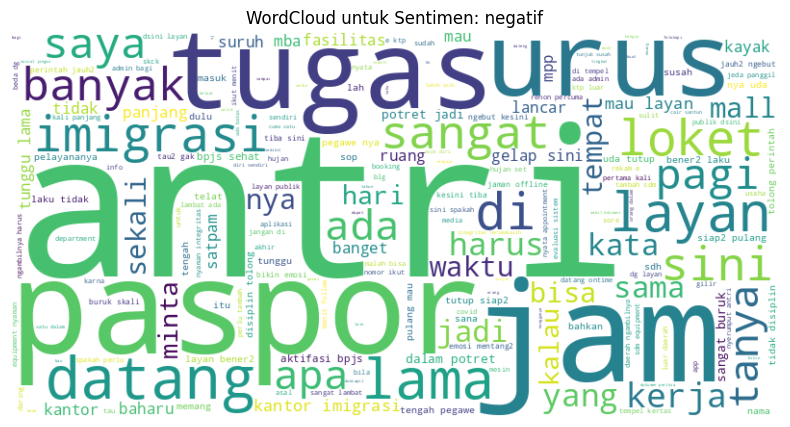

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df['review'] = df['review'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

for label in df['sentimen'].unique():
    combined_text = ' '.join(df[df['sentimen'] == label]['review'])
    generate_wordcloud(combined_text, f"WordCloud untuk Sentimen: {label}")

/tmp/ipython-input-536105647.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette='Set2')


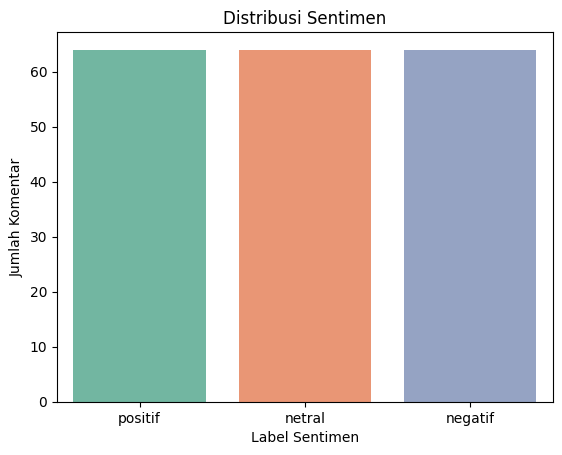

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sentimen_counts = df['sentimen'].value_counts()

sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette='Set2')
plt.title("Distribusi Sentimen")
plt.ylabel("Jumlah Komentar")
plt.xlabel("Label Sentimen")
plt.show()

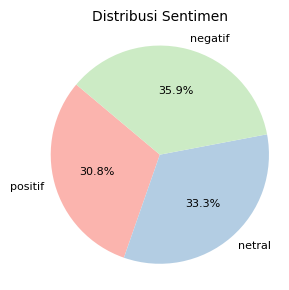

In [19]:
sentimen_count = Counter(y_pred)

label_ids = list(sentimen_count.keys())
jumlah = list(sentimen_count.values())

label_names = le.inverse_transform(label_ids)
colors = ['lightcoral', 'gold', 'mediumseagreen']

plt.figure(figsize=(3, 3))
plt.pie(
    jumlah,
    labels=label_names,
    colors=plt.cm.Pastel1.colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 8},
    radius=0.8
)
plt.title("Distribusi Sentimen", fontsize=10)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [20]:
def preprocess_input(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()

    for key, value in norm.items():
        text = text.replace(key, value)

    text = stop_remover.remove(text)
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

def predict_sentiment(text):
    cleaned_text = preprocess_input(text)

    tfidf_vector = vectorizer.transform([cleaned_text])

    prediction = model.predict(tfidf_vector)

    prediction_label = le.inverse_transform(prediction)[0]

    return prediction_label

In [22]:
input_text = "tempat yang pas untuk segala urusan administrasi"
hasil_sentimen = predict_sentiment(input_text)

print("Teks:", input_text)
print("Prediksi Sentimen:", hasil_sentimen)

Teks: tempat yang pas untuk segala urusan administrasi
Prediksi Sentimen: positif
